In [1]:
using SciMLBase
using OrdinaryDiffEq
using ForwardDiff
import ForwardDiff: jacobian

using StaticArrays
using LinearAlgebra
using Statistics

using JLD2
using Dates

using PyPlot

In [2]:
abstract type ODEType end
abstract type AbstractTask end

---
## Загрузка библиотек и модулей

---

In [180]:
include("Utils\\Anon_Utils.jl")
include("Utils\\CallBack_Utils.jl")
include("Utils\\Computation_Utils.jl")
include("Tasks\\ODE_Solving_Task.jl")
include("ODEs\\BS_ODE.jl")
include("Utils\\Visualization_Utils.jl")
include("Utils\\Period_Utils.jl")
include("Utils\\Session_Utils.jl")


---

## Создание сессии для сохранения результатов

---

In [4]:
#ses = Session("Some Session", Result_Folder_Name = "Test Results")

---

## Исходная система (3 ДУ)

---

In [5]:
ODE_Parameters = Dict("K" => 0.4,
                         "r" => 0.1,
                         "a2" => pi/2,
                         "a4" => pi)

Sngl = BS_ODE_Sngl(ODE_Parameters)

time_span = 10000.0
ic = [2.941592653589793, 0.2, 0.4]

trans_time = 0.0
alg = DP8()
callback = "x -> sin(x[1] - 0.25)"
kwargs = Dict(:dt => 1e-1, :abstol => 1e-13, :reltol => 1e-13, :maxiters => 1e10)


ODESolve = ODESolve_Task(Sngl, time_span, ic; trans_time, alg, callback, kwargs)

[ODE::BS_ODE_Sngl]: [K::Float64]: 0.4
[r::Float64]: 0.1
[a2::Float64]: 1.5707963267948966
[a4::Irrational{:π}]: π
[P::Vector{Real}]: Real[-0.4, -0.4, -1.2246467991473532e-16]

[time_span::Float64]: 10000.0
[init_cond::Vector{Float64}]: [2.941592653589793, 0.2, 0.4]
[trans_time::Float64]: 0.0
[alg::DP8{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}]: DP8(stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false))
[callback::String]: x -> sin(x[1] - 0.25)
[kwargs::Dict{Symbol, Any}]: Dict{Symbol, Any}(:maxiters => 1.0e10, :reltol => 1.0e-13, :abstol => 1.0e-13, :dt => 0.1)
[solution::Nothing]: nothing


In [6]:
sol = ODESolve()

[t]: 6825-element Vector{Float64}
[y]: 3-element Vector{Vector{Float64}} with size 6825
[t_events]: 1-element Vector{Vector{Float64}} with size 16
[y_events]: 1-element Vector{Matrix{Float64}} with size 16x3
[retcode]: Success


### Time Series

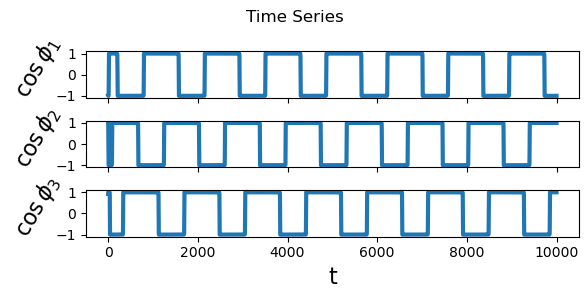

In [7]:
projFunc = "projCos"
varNames = ["\\phi_1", "\\phi_2", "\\phi_3"]
title = "Time Series"
plotKwargs = Dict(:linewidth => 3)

TS_properties = Dict("projFunc" => projFunc, "varNames" => varNames, "title" => title, "kwargs" => plotKwargs)
plotTimeSeries(sol; plot_properties = TS_properties);

### Poincare

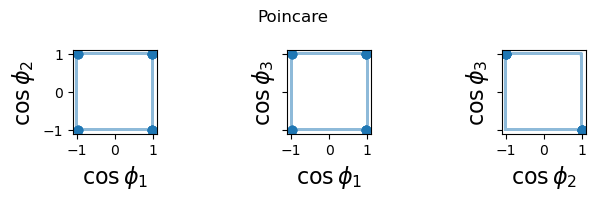

In [8]:
#savePath = "test.png"
projFunc = "projCos"
varNames = ["\\phi_1", "\\phi_2", "\\phi_3", "\\psi_1", "\\psi_2", "\\psi_3"]
title = "Poincare"
plotKwargs = Dict(:linewidth => 1)
showEvents = true
varPairs = [[[0, 1], [0, 2], [1, 2]]]

Pcr_properties = Dict("projFunc" => projFunc,
                     "varNames" => varNames,
                     "title" => title,
                     "showEvents" => showEvents,
                     "varPairs" => varPairs,
                     "kwargs" => plotKwargs)
plotPoincare(sol, plot_properties = Pcr_properties);

### Return time

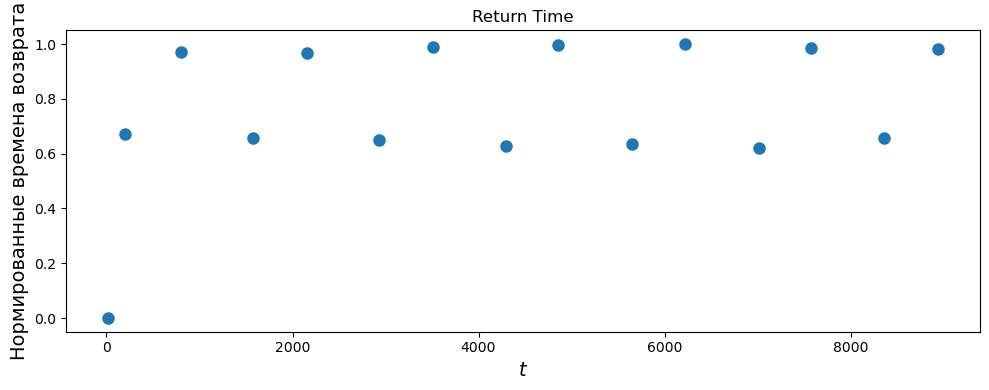

In [9]:
#savePath = "test.png"
normFunc = "normDefault"
title = "Return Time"
plotKwargs = Dict(:linewidth => 3)

RT_properties = Dict("normFunc" => normFunc, "title" => title, "kwargs" => plotKwargs)
plotReturnTime(sol, plot_properties = RT_properties);

---

## Объединенная система (6 ДУ)

---

In [88]:
ODE_Parameters = Dict("K" => 1.5789473684210527,
                         "r" => 0.39473684210526316,
                         "a2" => pi/2,
                         "a4" => 3.24685581148453,
                         "Eps" => 0.1)
Couple_function = "x -> 1 - cos(x)"
#Couple_function = "x -> 1/(exp(10*cos(x)))"

Duo = BS_ODE_Duo(ODE_Parameters, Couple_function)

time_span = 50.0
#ic = [2.941592653589793, 0.2, 0.4, 2.941592653589793, 0.4, 0.2]

val = 0.1
ic = [pi - val, pi - val, val, pi - val, val, pi - val]
#ic = [2.941592653589793, 1.2, 1.4, 2.941592653589793, 0.4, 0.2]
#ic = [3.278216370848396e-14,
#        4.237894430800192e-8,
#        3.141592780256459,
#        3.278216370848396e-14,
#        3.141592780256459,
#        4.237894430800192e-8]

trans_time = 0.0
alg = DP8()
callback = "x -> cos(x[1])"
kwargs = Dict(:dtmax => 1e-1, :abstol => 1e-13, :reltol => 1e-13, :maxiters => 1e10)


ODESolve = ODESolve_Task(Duo, time_span, ic; trans_time, alg, callback, kwargs)

[ODE::BS_ODE_Duo]: [Forward_ODE::BS_ODE_Sngl]:
[K::Float64]: 1.5789473684210527
[r::Float64]: 0.39473684210526316
[a2::Float64]: 1.5707963267948966
[a4::Float64]: 3.24685581148453
[P::Vector{Real}]: Real[-1.5702078118098561, -1.5789473684210527, -1.2246467991473532e-16]

[Backward_ODE::BS_ODE_Sngl]:
[K::Float64]: -1.5789473684210527
[r::Float64]: 0.39473684210526316
[a2::Float64]: 1.5707963267948966
[a4::Float64]: 3.24685581148453
[P::Vector{Real}]: Real[1.5702078118098561, -1.5789473684210527, -1.2246467991473532e-16]

[Eps::Float64]: 0.1
[Couple::AnonFunc]: #137: x -> 1 - cos(x)


[time_span::Float64]: 50.0
[init_cond::Vector{Float64}]: [3.041592653589793, 3.041592653589793, 0.1, 3.041592653589793, 0.1, 3.041592653589793]
[trans_time::Float64]: 0.0
[alg::DP8{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}]: DP8(stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false))
[callback::String]: x -> cos(x[1])

In [89]:
sol = ODESolve()

[t]: 967-element Vector{Float64}
[y]: 6-element Vector{Vector{Float64}} with size 967
[t_events]: 1-element Vector{Vector{Float64}} with size 7
[y_events]: 1-element Vector{Matrix{Float64}} with size 7x6
[retcode]: Success


### Time Series

In [90]:
#savePath = "test.png"
projFunc = "projCos"
varNames = ["\\phi_1", "\\phi_2", "\\phi_3", "\\psi_1", "\\psi_2", "\\psi_3"]
title = "Time Series"
plotKwargs = Dict(:linewidth => 3)

TS_properties = Dict("projFunc" => projFunc, "varNames" => varNames, "title" => title, "kwargs" => plotKwargs)

Dict{String, Any} with 4 entries:
  "kwargs"   => Dict(:linewidth=>3)
  "varNames" => ["\\phi_1", "\\phi_2", "\\phi_3", "\\psi_1", "\\psi_2", "\\psi_…
  "projFunc" => "projCos"
  "title"    => "Time Series"

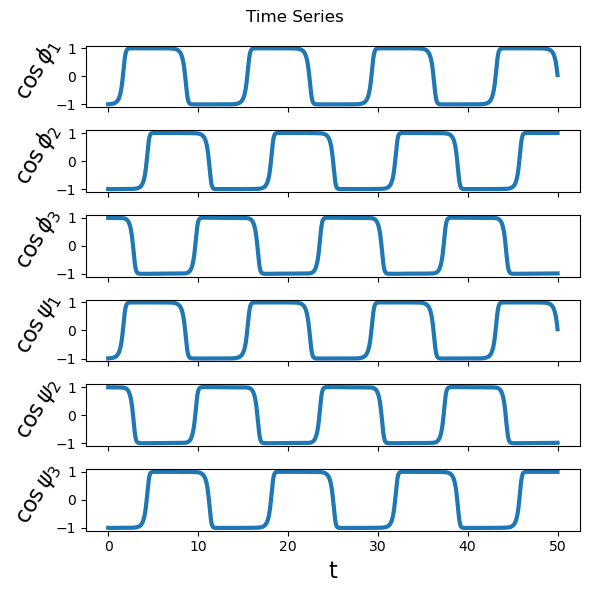

In [91]:
fig = plotTimeSeries(sol; plot_properties = TS_properties);

### Poincare

In [92]:
#savePath = "test.png"
projFunc = "projCos"
varNames = ["\\phi_1", "\\phi_2", "\\phi_3", "\\psi_1", "\\psi_2", "\\psi_3"]
title = "Poincare"
plotKwargs = Dict(:linewidth => 1)
showEvents = true
varPairs = [[[0, 1], [0, 2], [1, 2]],
            [[3, 4], [3, 5], [4, 5]],
            [[0, 3], [0, 4], [0, 5]],
            [[1, 3], [1, 4], [1, 5]],
            [[2, 3], [2, 4], [2, 5]]]

Pcr_properties = Dict("projFunc" => projFunc,
                     "varNames" => varNames,
                     "title" => title,
                     "showEvents" => showEvents,
                     "varPairs" => varPairs,
                     "kwargs" => plotKwargs)

Dict{String, Any} with 6 entries:
  "varPairs"   => [[[0, 1], [0, 2], [1, 2]], [[3, 4], [3, 5], [4, 5]], [[0, 3],…
  "showEvents" => true
  "kwargs"     => Dict(:linewidth=>1)
  "varNames"   => ["\\phi_1", "\\phi_2", "\\phi_3", "\\psi_1", "\\psi_2", "\\ps…
  "projFunc"   => "projCos"
  "title"      => "Poincare"

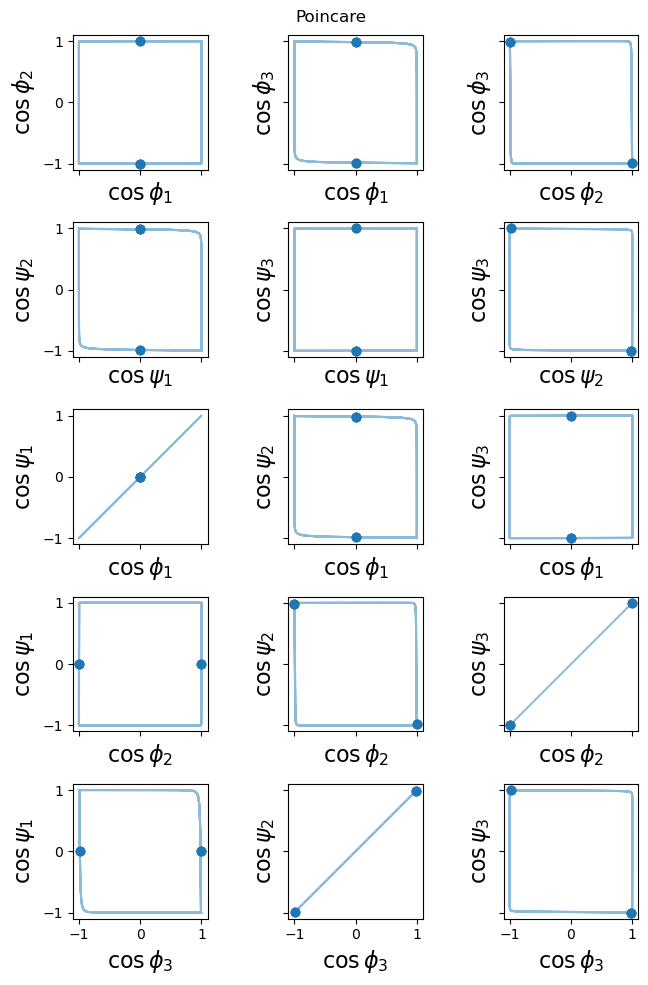

In [93]:
fig = plotPoincare(sol, plot_properties = Pcr_properties);

### Return time

In [94]:
#savePath = "test.png"
normFunc = "normDefault"
title = "Return Time"
plotKwargs = Dict(:linewidth => 3)

RT_properties = Dict("normFunc" => normFunc, "title" => title, "kwargs" => plotKwargs)

Dict{String, Any} with 3 entries:
  "normFunc" => "normDefault"
  "kwargs"   => Dict(:linewidth=>3)
  "title"    => "Return Time"

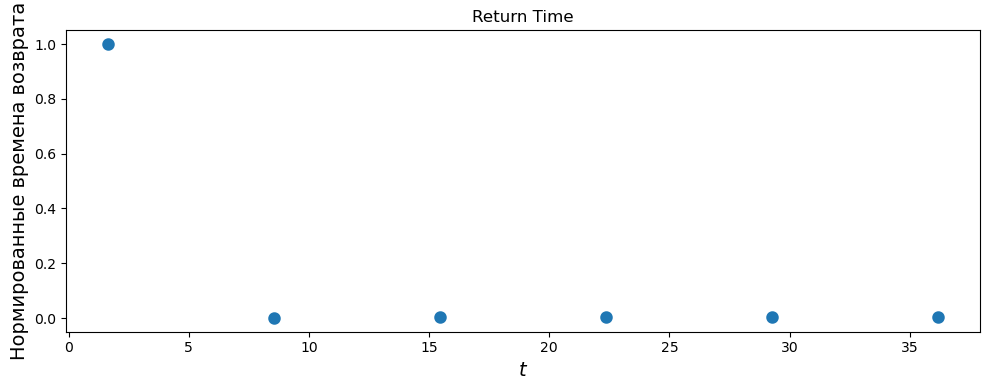

In [96]:
fig = plotReturnTime(sol, plot_properties = RT_properties);

### Activation Diagram

In [97]:
varNames = ["\\phi_1", "\\phi_2", "\\phi_3", "\\psi_1", "\\psi_2", "\\psi_3"]
title = "Activation Diagram"

AD_properties = Dict("varNames" => varNames, "title" => title)

Dict{String, Any} with 2 entries:
  "varNames" => ["\\phi_1", "\\phi_2", "\\phi_3", "\\psi_1", "\\psi_2", "\\psi_…
  "title"    => "Activation Diagram"

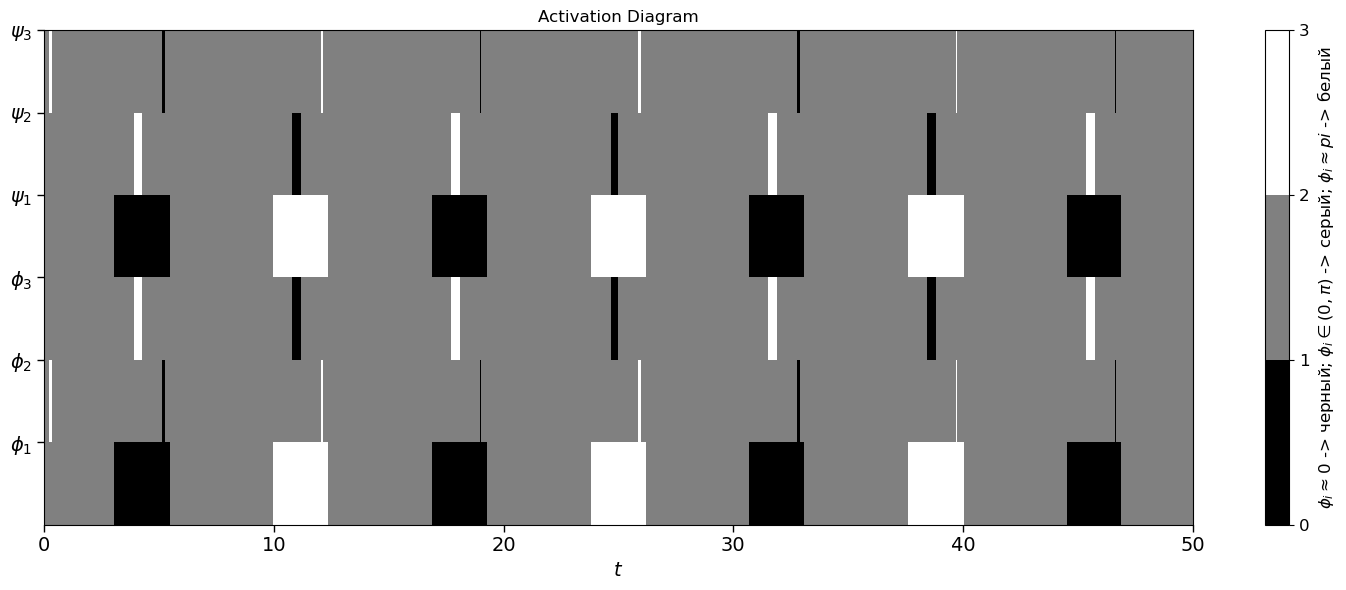

In [98]:
fig = plotActivationDiagram(sol, plot_properties = AD_properties);

### Period

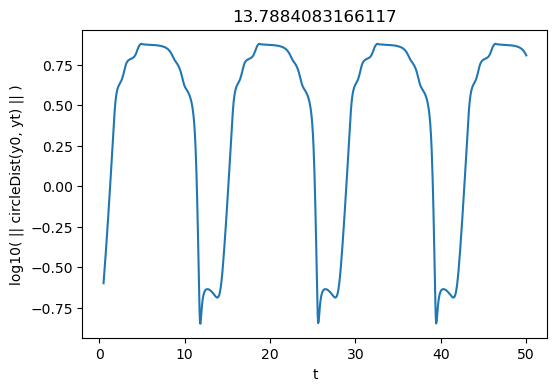

In [182]:
plotNorms(sol; skip_points = 10, norm_arg = 2)

In [183]:
period = getPeriodTime(sol)

13.7884083166117

### Syncs

In [184]:
syncs = BS_Syncs(sol)

Synchronization: ["phi_1 => psi_1", "phi_2 => psi_3", "phi_3 => psi_2"] with delay: 0.0


---

## Редуцированная система (3 ДУ)

---

In [185]:
Red = BS_ODE_Red(ODE_Parameters, Couple_function, syncs)

time_span = period
ic = [y[1] for y in sol.y[1:3]]

RedODESolve = ODESolve_Task(Red, time_span, ic; alg, kwargs)

[ODE::BS_ODE_Red]: [BS_ODE::BS_ODE_Sngl]:
[K::Float64]: 1.5789473684210527
[r::Float64]: 0.39473684210526316
[a2::Float64]: 1.5707963267948966
[a4::Float64]: 3.24685581148453
[P::Vector{Real}]: Real[-1.5702078118098561, -1.5789473684210527, -1.2246467991473532e-16]

[Syncs::BS_Syncs]:
Synchronization: ["phi_1 => psi_1", "phi_2 => psi_3", "phi_3 => psi_2"] with delay: 0.0

[Eps::Float64]: 0.1
[Couple::AnonFunc]: #330: x -> 1 - cos(x)


[time_span::Float64]: 13.7884083166117
[init_cond::Vector{Float64}]: [3.041592653589793, 3.041592653589793, 0.1]
[trans_time::Float64]: 0.0
[alg::DP8{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}]: DP8(stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false))
[callback::Nothing]: nothing
[kwargs::Dict{Symbol, Any}]: Dict{Symbol, Any}(:maxiters => 1.0e10, :reltol => 1.0e-13, :abstol => 1.0e-13, :dtmax => 0.1)
[solution::Nothing]: nothing


In [186]:
red_sol = RedODESolve()

[t]: 285-element Vector{Float64}
[y]: 3-element Vector{Vector{Float64}} with size 285
[t_events]: 1-element Vector{Vector{Float64}} with size 0
[y_events]: 1-element Vector{Matrix{Float64}} with size 0x0
[retcode]: Success


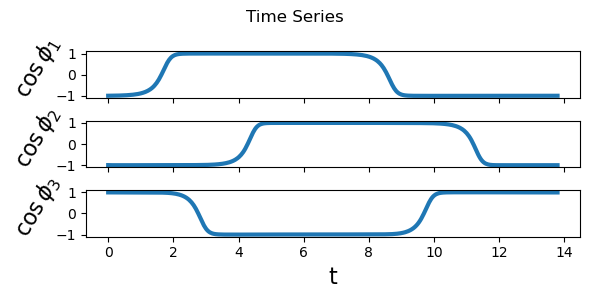

In [187]:
fig = plotTimeSeries(red_sol; plot_properties = TS_properties);

---

## Редуцированная система + система в вариациях (3 + 6х6 ДУ)

---

In [188]:
custom_Jacobian = z -> jacobian((y, x) -> Duo(y, x, [], 0), zeros(6), [z; Red.Syncs(z)])

#334 (generic function with 1 method)

In [189]:
Red_tg = TangentODE(Red, custom_Jacobian, 3, 6)

time_span = period
u0 = [y[1] for y in sol.y[1:3]]
Q0 = diagm(ones(6))


ODESolve = TanODESolve_Task(Red_tg, time_span, u0, Q0; alg, kwargs)

[ODE::TangentODE]: [ODE::BS_ODE_Red]: [BS_ODE::BS_ODE_Sngl]:
[K::Float64]: 1.5789473684210527
[r::Float64]: 0.39473684210526316
[a2::Float64]: 1.5707963267948966
[a4::Float64]: 3.24685581148453
[P::Vector{Real}]: Real[-1.5702078118098561, -1.5789473684210527, -1.2246467991473532e-16]

[Syncs::BS_Syncs]:
Synchronization: ["phi_1 => psi_1", "phi_2 => psi_3", "phi_3 => psi_2"] with delay: 0.0

[Eps::Float64]: 0.1
[Couple::AnonFunc]: #330: x -> 1 - cos(x)


[Jacobian::var"#334#336"]: #334
[ODEDim::Int64]: 3
[JacDim::Int64]: 6

[time_span::Float64]: 13.7884083166117
[u0::Vector{Float64}]: [3.041592653589793, 3.041592653589793, 0.1]
[Q0::Matrix{Float64}]: [1.0 0.0 0.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0 0.0 0.0; 0.0 0.0 1.0 0.0 0.0 0.0; 0.0 0.0 0.0 1.0 0.0 0.0; 0.0 0.0 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 0.0 0.0 1.0]
[alg::DP8{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}]: DP8(stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = s

In [190]:
tansol = ODESolve()

[t]: 425-element Vector{Float64}
[y]: 39-element Vector{Vector{Float64}} with size 425
[t_events]: 1-element Vector{Vector{Float64}} with size 0
[y_events]: 1-element Vector{Matrix{Float64}} with size 0x0
[retcode]: Success


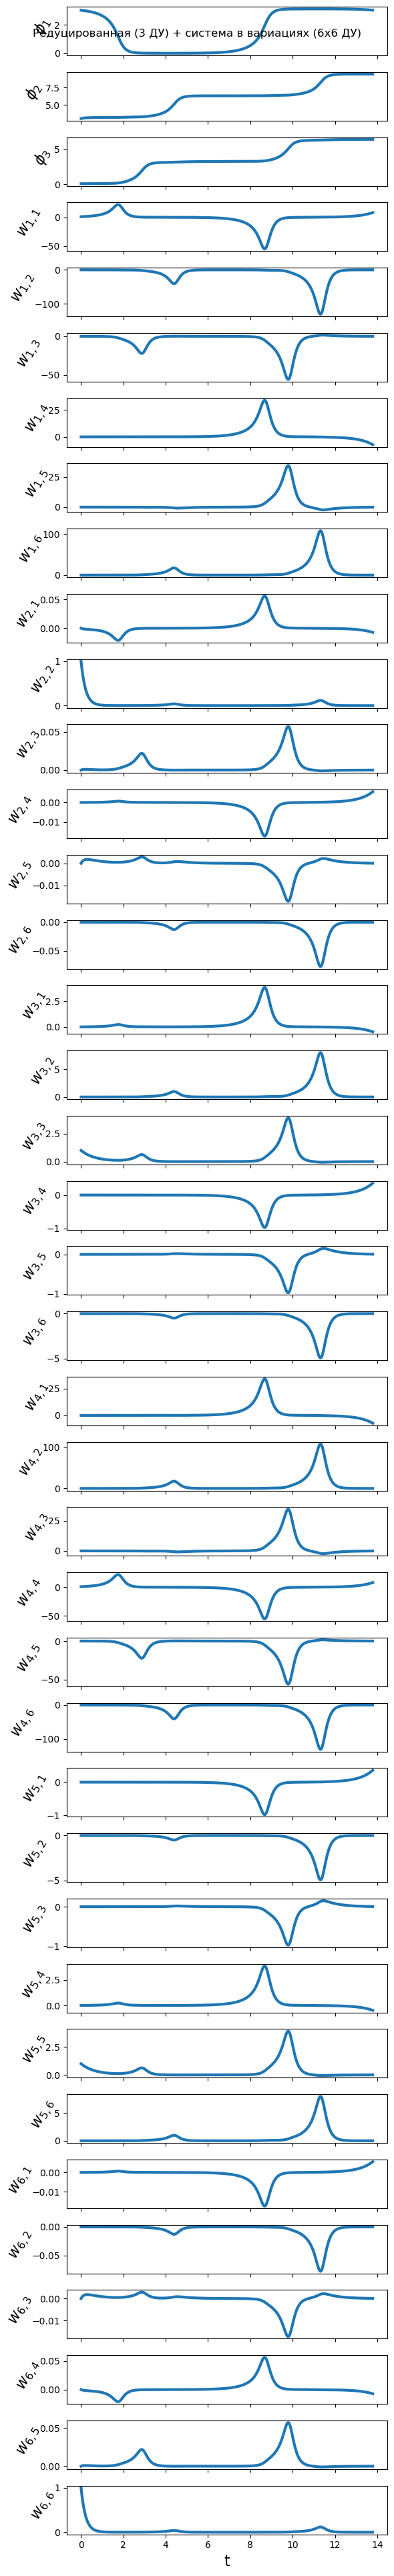

In [195]:
varNames = cat(["\\phi_1", "\\phi_2", "\\phi_3"], ["w_{$i,$j}" for i in 1:6 for j in 1:6], dims = 1)
title = "Редуцированная (3 ДУ) + система в вариациях (6x6 ДУ)"
plotKwargs = Dict(:linewidth => 3)

fig = plotTimeSeries(tansol; plot_properties = Dict("varNames" => varNames, "title" => title, "kwargs" => plotKwargs));

In [197]:
fig.savefig("image.pdf")

In [192]:
mono = reshape([t[end] for t in tansol.y[4:39]], (6, 6))

6×6 Matrix{Float64}:
  8.14375     -0.00712634  -0.477052     …   0.356651      0.00550889
 -0.00861236   7.62563e-6   0.000511785     -0.000360266  -5.59117e-6
  0.0184756   -3.41954e-7   0.000208041      0.00380735    5.42202e-5
 -7.25598      0.00550889   0.356651        -0.477052     -0.00712634
 -0.0480218    5.42202e-5   0.00380735       0.000208041  -3.41954e-7
  0.00749611  -5.59117e-6  -0.000360266  …   0.000511785   7.62563e-6

In [198]:
show(mono)

[8.143754348180567 -0.007126343494647748 -0.4770517138375476 -7.255984774839277 0.35665091652717057 0.005508889555026944; -0.008612356913695078 7.6256318762850015e-6 0.0005117846237342606 0.007496114499394462 -0.00036026611999024087 -5.591167045307691e-6; 0.018475604542493678 -3.419539309832073e-7 0.000208040744717472 -0.048021812616631486 0.00380734981281955 5.422016390739658e-5; -7.255984774839252 0.005508889555026979 0.3566509165271701 8.143754348180579 -0.4770517138375473 -0.007126343494647689; -0.04802181261663153 5.4220163907397e-5 0.003807349812819551 0.018475604542493678 0.0002080407447174695 -3.419539309831393e-7; 0.007496114499394442 -5.591167045307731e-6 -0.0003602661199902407 -0.00861235691369509 0.0005117846237342606 7.625631876284944e-6]

In [193]:
eigen(mono)

Eigen{Float64, Float64, Matrix{Float64}, Vector{Float64}}
values:
6-element Vector{Float64}:
  3.85522972734472e-19
  2.8553607451840625e-18
  6.918547272833534e-7
  8.247811852210166e-6
  0.8917787505518228
 15.39615233889593
vectors:
6×6 Matrix{Float64}:
 -0.0010146    0.000511849  -0.0381902  0.0950381  -0.706715      0.7071
 -0.998999     0.473881      0.0213073  0.0110803   0.000888596  -0.000739642
  0.00114435  -0.00446077   -0.705753   0.700603    0.0235207     0.00305332
  1.13974e-5   0.000911717   0.0381902  0.0950381  -0.706715     -0.7071
  0.00428121  -0.00323822    0.705753   0.700603    0.0235207    -0.00305332
  0.0445021    0.880571     -0.0213073  0.0110803   0.000888596   0.000739642